# House Price Analysis with Linear Regression - Models and Predictions
By Cassie Nutter

---
___
***

## Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)
warnings.filterwarnings(action= 'ignore', category=DeprecationWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_features_clean', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18918 entries, 0 to 18917
Data columns (total 99 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           18918 non-null  float64
 1   sqft_living     18918 non-null  int64  
 2   sqft_lot        18918 non-null  int64  
 3   floors          18918 non-null  int64  
 4   waterfront      18918 non-null  int64  
 5   condition       18918 non-null  int64  
 6   yr_built        18918 non-null  int64  
 7   year_sold       18918 non-null  int64  
 8   grade_5_6       18918 non-null  int64  
 9   grade_7_8       18918 non-null  int64  
 10  grade_9_11      18918 non-null  int64  
 11  has_basement    18918 non-null  int64  
 12  viewed          18918 non-null  int64  
 13  had_renovation  18918 non-null  int64  
 14  bed_2           18918 non-null  int64  
 15  bed_3           18918 non-null  int64  
 16  bed_4           18918 non-null  int64  
 17  bed_5           18918 non-null 

## Modeling and Prediction

### Feature Selection

Check correlation among features again. Making sure not to pick features with a strong correlation to each other to avoid multicollinearity.


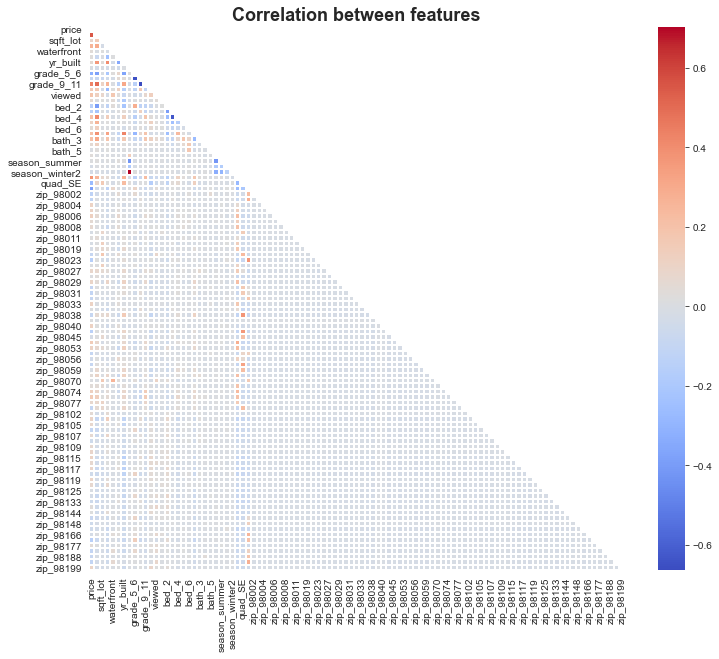

In [4]:
corr = df.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's see which features have the highest correlations.

In [5]:
df_corr_stack = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

df_corr_stack[(df_corr_stack.cc > .55) & (df_corr_stack.cc < 1)]

,cc
pairs,
"(season_winter2, year_sold)",0.703979
"(grade_9_11, grade_7_8)",0.663331
"(grade_5_6, grade_7_8)",0.645486
"(bed_4, bed_3)",0.627719
"(price, sqft_living)",0.554367


#### Stepwise Selection

In [6]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        if not changed:
            break
    return included

In [7]:
# Comment out to reduce scrolling
y = df['price']
X = df.drop('price', axis= 1)

result = stepwise_selection(X, y, verbose= True)
print ('resulting features:')
print (result)

Add  grade_9_11                     with p-value 0.0
Add  grade_7_8                      with p-value 0.0
Add  quad_SW                        with p-value 0.0
Add  quad_SE                        with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 2.78779e-196
Add  viewed                         with p-value 1.1372e-109
Add  zip_98106                      with p-value 8.60976e-98
Add  zip_98004                      with p-value 3.04514e-92
Add  zip_98155                      with p-value 3.68798e-76
Add  zip_98118                      with p-value 6.69044e-83
Add  zip_98133                      with p-value 3.13074e-84
Add  zip_98108                      with p-value 1.59737e-83
Add  zip_98028                      with p-value 2.24518e-58
Add  zip_98019                      with p-value 3.65994e-60
Add  zip_98040                      with p-value 7.76087e-57
Add  zip_98178                      with p-value 8.4835e-55
Add

The stepwise selection function suggested some of the following features:


|           |            |           |            |        |          |         |            |
|-----------|------------|-----------|------------|--------|----------|---------|------------|
|grade_5_6| yr_built |quad_SW|condition|sqft_living|bed_5 |bed_2   |had_renovation|
|grade_7_8| year_sold|quad_SE|floors   |sqft_lot   |bed_6 |bath_2|season_winter2 | 
|grade_9_11|yr_built |quad_NW|viewed|waterfront |bed_4 |bath_3  |79 zipcodes|


In [8]:
step_select_df = df[['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 
                     'viewed', 'zip_98106', 'condition', 'grade_7_8', 
                     'zip_98004', 'yr_built', 'zip_98155', 'zip_98133', 
                     'zip_98118', 'zip_98108', 'floors', 'zip_98040', 
                     'zip_98019', 'zip_98028', 'zip_98065', 'zip_98056', 
                     'zip_98178', 'zip_98126', 'zip_98034', 'zip_98125', 
                     'zip_98014', 'sqft_lot', 'zip_98146', 'zip_98011', 
                     'waterfront', 'zip_98072', 'zip_98166', 'year_sold', 
                     'zip_98112', 'zip_98119', 'zip_98024', 'zip_98199', 
                     'zip_98105', 'zip_98005', 'zip_98109', 'zip_98033', 
                     'zip_98103', 'zip_98115', 'zip_98117', 'zip_98107', 
                     'zip_98102', 'zip_98122', 'zip_98052', 'zip_98116', 
                     'has_basement', 'zip_98092', 'zip_98042', 'zip_98022', 
                     'zip_98006', 'zip_98023', 'zip_98030', 'had_renovation', 
                     'season_winter2', 'zip_98031', 'zip_98038', 'zip_98058', 
                     'zip_98002', 'zip_98168', 'zip_98003', 'zip_98032', 
                     'zip_98198', 'zip_98075', 'zip_98053', 'zip_98029', 
                     'zip_98055', 'zip_98188', 'bed_5', 'zip_98008', 
                     'zip_98074', 'zip_98027', 'zip_98007', 'zip_98136', 
                     'zip_98144', 'zip_98177', 'zip_98077', 'zip_98059', 
                     'zip_98045', 'zip_98070', 'zip_98010', 'zip_98039', 
                     'bed_6', 'bath_2', 'bath_3', 'zip_98148', 'quad_NW']]

#### Variance Inflation Factor

In [9]:
# check VIF (variance inflation factor)
# Consider removing features with VIF > 5 

X = df.drop('price', axis= 1)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

vif_data['VIF'] = [vif(X.values, i) for i in range(len(X.columns))]

print (vif_data[vif_data['VIF'] >= 5])

        feature           VIF
0   sqft_living     27.417757
2        floors     15.842410
4     condition     37.336472
5      yr_built  12189.140022
6     year_sold  12941.594486
7     grade_5_6     83.199898
8     grade_7_8    542.160510
9    grade_9_11     90.251943
13        bed_2     15.732505
14        bed_3     53.826651
15        bed_4     34.702163
16        bed_5      7.975621
26      quad_NW     15.231868
27      quad_SE     15.074312
28      quad_SW     11.567711


Stepwise Selection thought we could use some columns based on a low p-value. Variance Inflation Factor looked at the collinearity among the features. We will have to carefully consider both.

## Model 1: Has Everything

Only feature selection and engineering changes applied to baseline

In [10]:
y = df['price']
X = df.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train = pd.concat([X_train, y_train], axis= 1)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14188, 98) (14188,)
(4730, 98) (4730,)


In [11]:
y = df_train['price']
X = df_train.drop('price', axis= 1)

X_int = sm.add_constant(X)
model= sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     607.9
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:05   Log-Likelihood:            -1.7930e+05
No. Observations:               14188   AIC:                         3.588e+05
Df Residuals:                   14089   BIC:                         3.595e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.217e+07   4.62e+06    -13.452      0.000   -7.12e+07   -5.31e+07
sqft_living      117.1458      1.631     71.840      0.000     113.949     120.342
sqft_lot           0.4002      0.022     18.480      0.000       0.358       0.443
floors          -991.6231   1548.830     -0.640      0.522   -4027.535    2044.289
waterfront       1.86e+05   1.39e+04     13.352      0.000    1.59e+05    2.13e+05
condition       2.043e+04   1111.316     18.387      0.000    1.83e+04    2.26e+04
yr_built        -216.5821     35.171     -6.158      0.000    -285.522    -147.642
year_sold       3.107e+04   2294.215     13.544      0.000    2.66e+04    3.56e+04
grade_5_6      -4103.4473   1.63e+04     -0.252      0.801   -3.61e+04    2.79e+04
grade_7_8       2.917e+04   1.64e+04      1.783      0.075   -2901.427    6.12e+04
grade_9_11      1.038e+05   1.66e+04      6.255      0.000    7.13e+04    1.36e+05
has_basement   -1.637e+04   1624.202    -10.081      0.000   -1.96e+04   -1.32e+04
viewed          6.541e+04   2745.116     23.826      0.000       6e+04    7.08e+04
had_renovation  2.398e+04   4043.080      5.930      0.000    1.61e+04    3.19e+04
bed_2           2642.0305   6533.611      0.404      0.686   -1.02e+04    1.54e+04
bed_3           6827.9358   6536.379      1.045      0.296   -5984.231    1.96e+04
bed_4           5292.7016   6731.874      0.786      0.432   -7902.662    1.85e+04
bed_5          -1.616e+04   7244.264     -2.230      0.026   -3.04e+04   -1956.032
bed_6          -3.951e+04   9380.801     -4.212      0.000   -5.79e+04   -2.11e+04
bath_2          1.344e+04   1777.354      7.564      0.000    9960.285    1.69e+04
bath_3          1.793e+04   3243.276      5.530      0.000    1.16e+04    2.43e+04
bath_4          3305.4274   1.11e+04      0.299      0.765   -1.84e+04     2.5e+04
bath_5          5.166e+04   3.14e+04      1.645      0.100   -9888.280    1.13e+05
season_spring   3889.2244   2215.862      1.755      0.079    -454.158    8232.607
season_summer   5180.0665   2015.140      2.571      0.010    1230.125    9130.008
season_winter1  4279.2973   2873.833      1.489      0.136   -1353.796    9912.390
season_winter2 -1.465e+04   3152.232     -4.647      0.000   -2.08e+04   -8470.207
quad_NW        -1.865e+04   4811.890     -3.876      0.000   -2.81e+04   -9218.977
quad_SE          -6.5e+04   5745.356    -11.313      0.000   -7.63e+04   -5.37e+04
quad_SW        -4.597e+04   5433.857     -8.459      0.000   -5.66e+04   -3.53e+04
zip_98002       -778.7083   7600.156     -0.102      0.918   -1.57e+04    1.41e+04
zip_98003       8962.4711   6868.945      1.305      0.192   -4501.571    2.24e+04
zip_98004       4.339e+05   1.15e+04     37.605      0.000    4.11e+05    4.56e+05
zip_98005       3.095e+05   1.07e+04     28.923      0.000    2.89e+05    3.31e+05
zip_98006   

### RMSE & Accuracy

In [12]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  74486.09586679323
Test RMSE:  75483.7731737365


In [13]:
# Find accuracy of test and train sets
# Accuracy is % of predictions it got correct
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.8744217418826
Accuracy score - test: 80.93843428585029


### Q-Q Plot

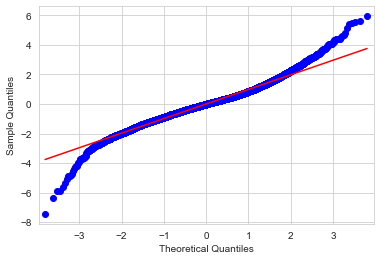

In [14]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig.show()

That Q-Q plot shows we have some thin 'tails' on our data.

While this model looks better than the baseline on a Q-Q plot and gives an okay $R^2$ value, we have to remember it doesn't meet the assumption of having little to no multicollinearity and still has features that are not statistically significant.

## Model 2: Remove Many Things
Select features suggested by stepwise selection function while removing those that may cause multicollinearity indicated by VIF.

In [15]:
df1 = step_select_df.copy()

In [16]:
df1.columns

Index(['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
       'zip_98106', 'condition', 'grade_7_8', 'zip_98004', 'yr_built',
       'zip_98155', 'zip_98133', 'zip_98118', 'zip_98108', 'floors',
       'zip_98040', 'zip_98019', 'zip_98028', 'zip_98065', 'zip_98056',
       'zip_98178', 'zip_98126', 'zip_98034', 'zip_98125', 'zip_98014',
       'sqft_lot', 'zip_98146', 'zip_98011', 'waterfront', 'zip_98072',
       'zip_98166', 'year_sold', 'zip_98112', 'zip_98119', 'zip_98024',
       'zip_98199', 'zip_98105', 'zip_98005', 'zip_98109', 'zip_98033',
       'zip_98103', 'zip_98115', 'zip_98117', 'zip_98107', 'zip_98102',
       'zip_98122', 'zip_98052', 'zip_98116', 'has_basement', 'zip_98092',
       'zip_98042', 'zip_98022', 'zip_98006', 'zip_98023', 'zip_98030',
       'had_renovation', 'season_winter2', 'zip_98031', 'zip_98038',
       'zip_98058', 'zip_98002', 'zip_98168', 'zip_98003', 'zip_98032',
       'zip_98198', 'zip_98075', 'zip_98053', 'zip_98029', 'zip

In [17]:
df1 = df1.drop(columns= ['sqft_living', 'floors', 'condition', 'yr_built',
                         'grade_9_11', 'grade_7_8', 'bed_5', 'quad_SE', 
                         'quad_SW', 'quad_NW', 'zip_98168', 'zip_98003', 
                         'zip_98023', 'zip_98032', 'zip_98198', 'zip_98188', 
                         'zip_98030', 'zip_98031', 'zip_98178', 'zip_98148', 
                         'season_winter2'], axis= 1)

In [18]:
y = df1['price']
X = df1.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 32)
df_train1 = pd.concat([X_train, y_train], axis= 1)

In [19]:
y = df_train1['price']
X = df_train1.drop('price', axis= 1)

X_int = sm.add_constant(X)
model1= sm.OLS(y, X_int).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     338.5
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:05   Log-Likelihood:            -1.8421e+05
No. Observations:               14188   AIC:                         3.686e+05
Df Residuals:                   14119   BIC:                         3.691e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.524e+07   3.83e+06     -6.595      0.000   -3.27e+07   -1.77e+07
viewed          1.049e+05   3745.036     28.010      0.000    9.76e+04    1.12e+05
zip_98106       4.519e+04   7085.495      6.377      0.000    3.13e+04    5.91e+04
zip_98004       4.545e+05   1.37e+04     33.120      0.000    4.28e+05    4.81e+05
zip_98155       1.175e+05   6305.576     18.630      0.000    1.05e+05     1.3e+05
zip_98133       1.225e+05   6012.652     20.376      0.000    1.11e+05    1.34e+05
zip_98118       1.148e+05   6103.572     18.816      0.000    1.03e+05    1.27e+05
zip_98108       7.174e+04   9300.610      7.713      0.000    5.35e+04       9e+04
zip_98040       4.435e+05   1.37e+04     32.316      0.000    4.17e+05     4.7e+05
zip_98019       9.814e+04   9400.256     10.440      0.000    7.97e+04    1.17e+05
zip_98028       1.584e+05   7586.628     20.885      0.000    1.44e+05    1.73e+05
zip_98065       1.844e+05   7483.499     24.644      0.000     1.7e+05    1.99e+05
zip_98056       1.099e+05   6606.063     16.639      0.000     9.7e+04    1.23e+05
zip_98126       1.342e+05   6980.436     19.231      0.000    1.21e+05    1.48e+05
zip_98034       1.705e+05   5803.264     29.382      0.000    1.59e+05    1.82e+05
zip_98125       1.697e+05   6630.594     25.599      0.000    1.57e+05    1.83e+05
zip_98014       8.454e+04   1.13e+04      7.480      0.000    6.24e+04    1.07e+05
sqft_lot           0.7314      0.031     23.741      0.000       0.671       0.792
zip_98146       6.127e+04   7745.239      7.910      0.000    4.61e+04    7.64e+04
zip_98011       1.767e+05   9206.207     19.192      0.000    1.59e+05    1.95e+05
waterfront      1.784e+05    2.1e+04      8.494      0.000    1.37e+05     2.2e+05
zip_98072       1.992e+05   8225.684     24.223      0.000    1.83e+05    2.15e+05
zip_98166       9.976e+04   8468.985     11.780      0.000    8.32e+04    1.16e+05
year_sold       1.264e+04   1899.625      6.652      0.000    8911.878    1.64e+04
zip_98112        3.59e+05    1.2e+04     29.971      0.000    3.36e+05    3.82e+05
zip_98119       3.328e+05   1.13e+04     29.518      0.000    3.11e+05    3.55e+05
zip_98024       1.163e+05   1.51e+04      7.702      0.000    8.67e+04    1.46e+05
zip_98199       3.084e+05   8509.274     36.248      0.000    2.92e+05    3.25e+05
zip_98105       3.336e+05   1.05e+04     31.663      0.000    3.13e+05    3.54e+05
zip_98005       3.677e+05   1.19e+04     30.909      0.000    3.44e+05    3.91e+05
zip_98109       3.246e+05   1.44e+04     22.493      0.000    2.96e+05    3.53e+05
zip_98033       2.967e+05   7313.335     40.564      0.000    2.82e+05    3.11e+05
zip_98103       2.641e+05   5757.195     45.882      0.000    2.53e+05    2.75e+05
zip_98115       2.866e+05   5953.418     48.137      0.000    2.75e+05    2.98e+05
zip_98117   

Ouch! Felt that right in the $R^2$! All of the calculation's scores dropped - some more significantly than others. Kurtosis is in the 3 range now - indicating the data is more normally distributed. The Jarque-Bera (JB) (another normality test) is six times less than it was in the first model.

### RMSE & Accuracy

In [20]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
diff = test_rmse - train_rmse
print (diff)

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

483.2079166318581
Train RMSE:  105307.15441075145
Test RMSE:  105790.3623273833


In [21]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  61.98430341789951
Accuracy score - test: 61.94087963292731


### Q-Q Plot

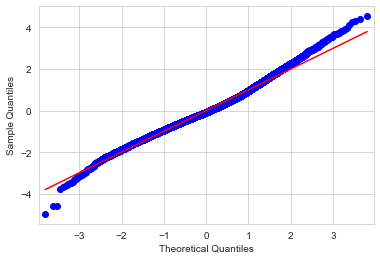

In [22]:
residuals = model1.resid
fig1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig1.show()

### Correlation Matrix

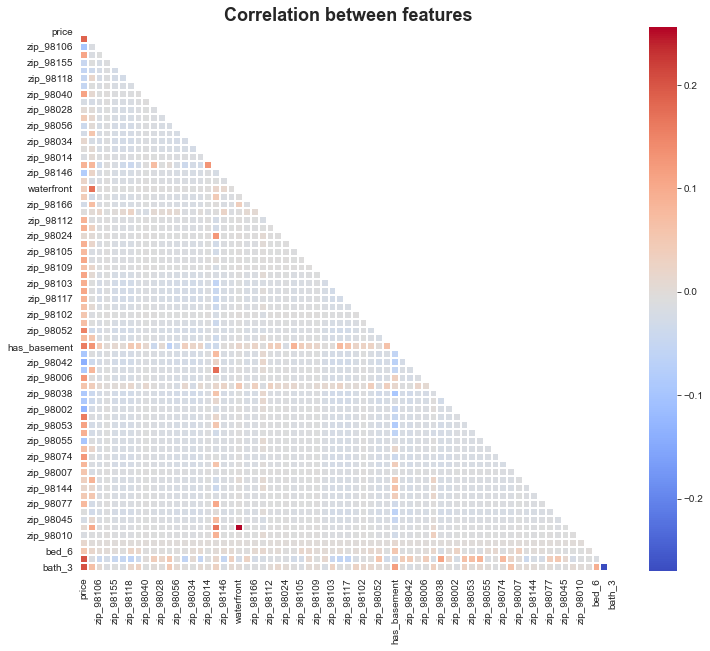

In [23]:
corr = df1.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df1.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

While this model meets normality assumptions better than the other model, it is does a poorer job at predicting housing prices.

## Model 3:  Not Using Zip Codes
Create a model that doesn't use zip codes, only quadrants created from latitude and longitude.

In [24]:
df_no_zip = df[['price', 'viewed', 'condition', 'waterfront', 'floors', 
          'grade_5_6', 'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built', 
          'sqft_living', 'bath_2', 'bed_5', 'sqft_lot', 'bed_2', 
          'had_renovation']]

In [25]:
y = df_no_zip['price']
X = df_no_zip.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state = 42)
df_train_nozip = pd.concat([X_train, y_train], axis= 1)

In [26]:
y = df_train_nozip['price']
X = df_train_nozip.drop('price', axis= 1)

X_int = sm.add_constant(X)
model_nozip = sm.OLS(y, X_int).fit()
model_nozip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     1858.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:07   Log-Likelihood:            -1.8332e+05
No. Observations:               14188   AIC:                         3.667e+05
Df Residuals:                   14172   BIC:                         3.668e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.779e+06   7.92e+04     22.472      0.000    1.62e+06    1.93e+06
viewed          5.923e+04   3495.914     16.943      0.000    5.24e+04    6.61e+04
condition       2.178e+04   1419.795     15.343      0.000     1.9e+04    2.46e+04
waterfront      1.922e+05   1.79e+04     10.746      0.000    1.57e+05    2.27e+05
floors          2.453e+04   1694.609     14.475      0.000    2.12e+04    2.79e+04
grade_5_6       -7.16e+04   2989.027    -23.953      0.000   -7.75e+04   -6.57e+04
grade_9_11      9.544e+04   3036.476     31.430      0.000    8.95e+04    1.01e+05
quad_SE        -1.671e+05   2349.128    -71.124      0.000   -1.72e+05   -1.62e+05
quad_SW        -1.905e+05   2396.797    -79.488      0.000   -1.95e+05   -1.86e+05
yr_built        -816.8656     39.787    -20.531      0.000    -894.854    -738.877
sqft_living      109.3875      1.719     63.644      0.000     106.019     112.756
bath_2          1.161e+04   1961.353      5.917      0.000    7761.399    1.55e+04
bed_5          -2.185e+04   3736.484     -5.848      0.000   -2.92e+04   -1.45e+04
sqft_lot           0.3200      0.027     12.044      0.000       0.268       0.372
bed_2           1.263e+04   2674.636      4.722      0.000    7386.530    1.79e+04
had_renovation  2.174e+04   5296.984      4.104      0.000    1.14e+04    3.21e+04
==============================================================================
Omnibus:                      455.209   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.054
Skew:                           0.312   Prob(JB):                    3.56e-153
Kurtosis:                       3.893   Cond. No.                     3.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [27]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  98880.70329606616
Test RMSE:  100884.39335475277


In [28]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  66.29554997122385
Accuracy score - test: 65.95139349250971


### Q-Q Plot

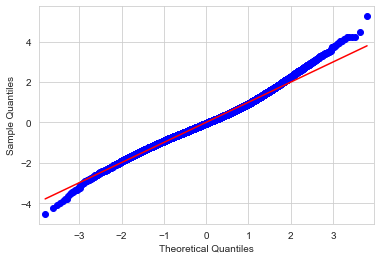

In [29]:
residuals = model_nozip.resid
fig2 = sm.graphics.qqplot(residuals, dist= stats.norm, line= 'r', fit= True)
fig2.show()

We see a drop in RMSE and accuracy in predictions from the first model, but do respect some normality assumptions. However, it appears have zip codes dramatically increases our ability to predict the prices.

## Model 4: Using Zip Codes
To get better at predicting prices, we will include the zip codes, but eliminate features that are not statistically significant.

In [30]:
df2 = step_select_df.copy()

In [31]:
# df2.columns

In [32]:
# remove features that have multicollinearity, very high VIF, 
# or p-value > 0.05
df2 = df2.drop(columns= ['year_sold', 'grade_7_8', 'zip_98092', 'zip_98023', 
                         'zip_98002', 'zip_98003', 'zip_98032', 'floors', 
                         'season_winter2', 'quad_NW', 'zip_98022'], axis= 1)

In [33]:
y = df2['price']
X = df2.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                    random_state = 32)
df_train2 = pd.concat([X_train, y_train], axis= 1)

In [34]:
y = df_train2['price']
X = df_train2.drop('price', axis= 1)

X_int = sm.add_constant(X)
model2 = sm.OLS(y, X_int).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     736.1
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:07   Log-Likelihood:            -1.7956e+05
No. Observations:               14188   AIC:                         3.593e+05
Df Residuals:                   14109   BIC:                         3.599e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.57e+05   6.61e+04      2.375      0.018    2.74e+04    2.86e+05
quad_SE         -5.31e+04   4447.586    -11.939      0.000   -6.18e+04   -4.44e+04
quad_SW        -4.539e+04   4653.037     -9.755      0.000   -5.45e+04   -3.63e+04
sqft_living      123.0377      1.418     86.764      0.000     120.258     125.817
grade_9_11      6.975e+04   2398.432     29.082      0.000     6.5e+04    7.45e+04
viewed          6.292e+04   2740.719     22.958      0.000    5.76e+04    6.83e+04
zip_98106       6.192e+04   6830.547      9.066      0.000    4.85e+04    7.53e+04
condition       1.982e+04   1112.815     17.808      0.000    1.76e+04     2.2e+04
zip_98004       4.109e+05   1.09e+04     37.818      0.000     3.9e+05    4.32e+05
yr_built         -75.0472     32.760     -2.291      0.022    -139.261     -10.833
zip_98155       9.546e+04   6396.727     14.924      0.000    8.29e+04    1.08e+05
zip_98133       1.086e+05   6249.877     17.370      0.000    9.63e+04    1.21e+05
zip_98118       1.089e+05   6340.844     17.172      0.000    9.65e+04    1.21e+05
zip_98108       6.638e+04   8096.737      8.199      0.000    5.05e+04    8.23e+04
zip_98040       3.688e+05   1.09e+04     33.956      0.000    3.48e+05     3.9e+05
zip_98019       5.485e+04   8104.337      6.768      0.000     3.9e+04    7.07e+04
zip_98028       1.021e+05   7059.206     14.469      0.000    8.83e+04    1.16e+05
zip_98065       9.747e+04   7006.652     13.911      0.000    8.37e+04    1.11e+05
zip_98056       7.035e+04   5822.592     12.083      0.000    5.89e+04    8.18e+04
zip_98178       2.325e+04   6135.598      3.789      0.000    1.12e+04    3.53e+04
zip_98126       1.357e+05   6774.615     20.025      0.000    1.22e+05    1.49e+05
zip_98034       1.408e+05   6122.056     22.999      0.000    1.29e+05    1.53e+05
zip_98125       1.551e+05   6571.820     23.596      0.000    1.42e+05    1.68e+05
zip_98014        4.42e+04   9258.970      4.773      0.000     2.6e+04    6.23e+04
sqft_lot           0.4425      0.022     19.899      0.000       0.399       0.486
zip_98146       6.888e+04   6331.422     10.879      0.000    5.65e+04    8.13e+04
zip_98011       1.169e+05   8000.353     14.618      0.000    1.01e+05    1.33e+05
waterfront      1.873e+05   1.52e+04     12.350      0.000    1.58e+05    2.17e+05
zip_98072       1.383e+05   7415.919     18.647      0.000    1.24e+05    1.53e+05
zip_98166       1.002e+05   6274.073     15.975      0.000    8.79e+04    1.13e+05
zip_98112       3.413e+05   9790.081     34.864      0.000    3.22e+05    3.61e+05
zip_98119       3.321e+05   9324.115     35.622      0.000    3.14e+05     3.5e+05
zip_98024       9.175e+04   1.17e+04      7.811      0.000    6.87e+04    1.15e+05
zip_98199       2.962e+05   7628.238     38.829      0.000    2.81e+05    3.11e+05
zip_98105   

### RMSE & Accuracy

In [35]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
diff = test_rmse - train_rmse
print (diff)

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

1024.4190718046593
Train RMSE:  75858.87220909016
Test RMSE:  76883.29128089482


In [36]:
# Find accuracy of test and train sets
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.27304920819398
Accuracy score - test: 79.89840722065897


### Q-Q Plot

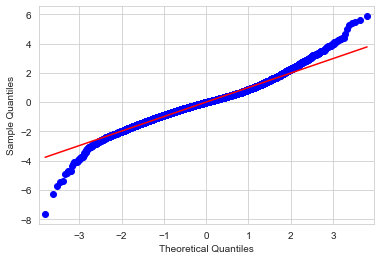

In [37]:
residuals = model2.resid
fig2 = sm.graphics.qqplot(residuals, dist= stats.norm, line= 'r', fit= True)
fig2.show()

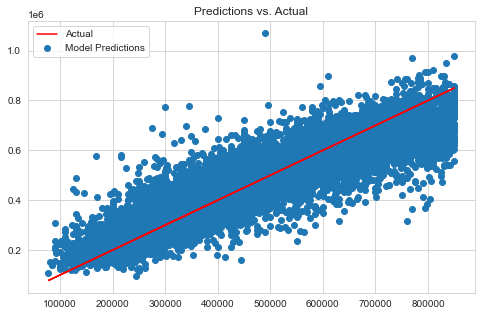

In [38]:
y_pred = linreg.predict(X_train)

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Predictions vs. Actual')
plt.legend()
plt.show()

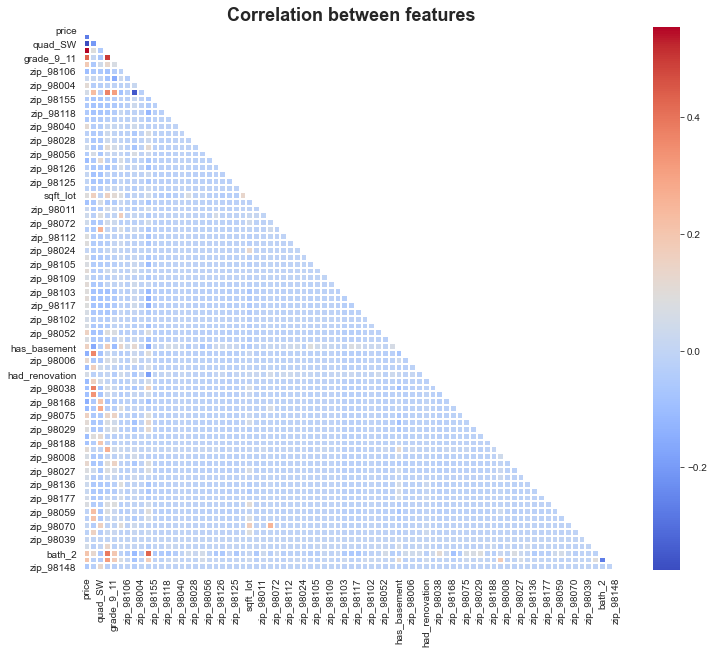

In [39]:
corr = df2.corr()

plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df2.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Our predictions are fairly close and 80% of the variations can be explained by this model, the data is still not normally distributed. Let's try to fix those "thin tails".

## Model 5: Log Transform Model 4

In [40]:
df3 = df2.copy()

In [41]:
df3.columns

Index(['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
       'zip_98106', 'condition', 'zip_98004', 'yr_built', 'zip_98155',
       'zip_98133', 'zip_98118', 'zip_98108', 'zip_98040', 'zip_98019',
       'zip_98028', 'zip_98065', 'zip_98056', 'zip_98178', 'zip_98126',
       'zip_98034', 'zip_98125', 'zip_98014', 'sqft_lot', 'zip_98146',
       'zip_98011', 'waterfront', 'zip_98072', 'zip_98166', 'zip_98112',
       'zip_98119', 'zip_98024', 'zip_98199', 'zip_98105', 'zip_98005',
       'zip_98109', 'zip_98033', 'zip_98103', 'zip_98115', 'zip_98117',
       'zip_98107', 'zip_98102', 'zip_98122', 'zip_98052', 'zip_98116',
       'has_basement', 'zip_98042', 'zip_98006', 'zip_98030', 'had_renovation',
       'zip_98031', 'zip_98038', 'zip_98058', 'zip_98168', 'zip_98198',
       'zip_98075', 'zip_98053', 'zip_98029', 'zip_98055', 'zip_98188',
       'bed_5', 'zip_98008', 'zip_98074', 'zip_98027', 'zip_98007',
       'zip_98136', 'zip_98144', 'zip_98177', 'zip_98077

In [42]:
# list of continuous features to log transform
cont = ['yr_built', 'sqft_living', 'sqft_lot']

In [43]:
df_cont = df3[cont]

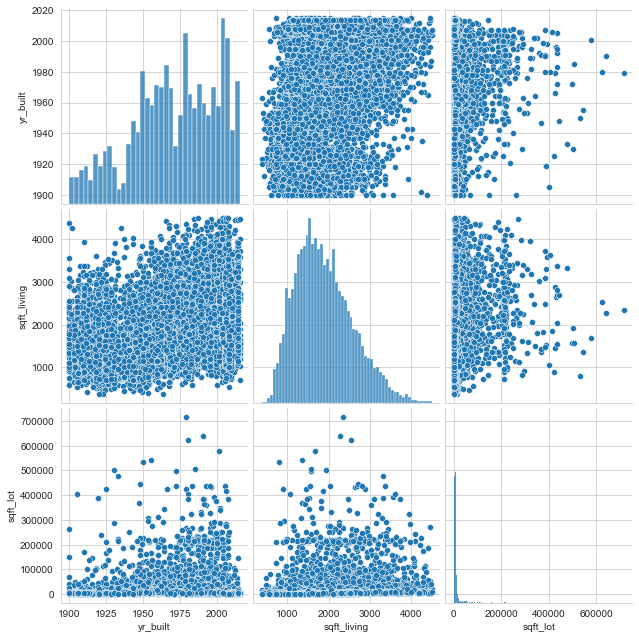

In [44]:
cont_pp = sns.pairplot(df_cont, height= 3)

Yikes. "sqft_living" is the only semi-normalish distribution.

In [45]:
log_names = [f'{column}_log' for column in df_cont.columns]

df_cont_log = np.log(df_cont)
df_cont_log.columns = log_names

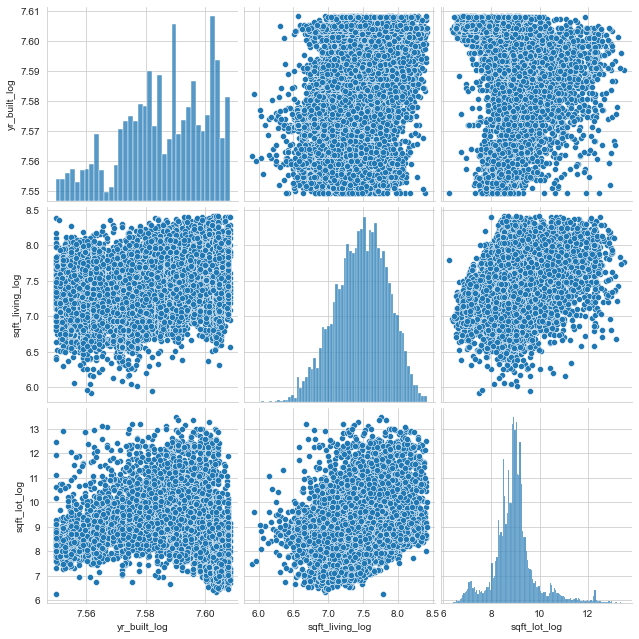

In [46]:
cont_pp2 = sns.pairplot(df_cont_log, height= 3)

"sqft_living" looks better and so does "sqft_lot". "yr_built" is still a bit messy, but better.

In [47]:
model4_log = pd.concat([df_cont_log, df3], axis= 1)
model4_log.head()

,yr_built_log,sqft_living_log,sqft_lot_log,price,quad_SE,quad_SW,sqft_living,grade_9_11,viewed,zip_98106,condition,zip_98004,yr_built,zip_98155,zip_98133,zip_98118,zip_98108,zip_98040,zip_98019,zip_98028,zip_98065,zip_98056,zip_98178,zip_98126,zip_98034,zip_98125,zip_98014,sqft_lot,zip_98146,zip_98011,waterfront,zip_98072,zip_98166,zip_98112,zip_98119,zip_98024,zip_98199,zip_98105,zip_98005,zip_98109,zip_98033,zip_98103,zip_98115,zip_98117,zip_98107,zip_98102,zip_98122,zip_98052,zip_98116,has_basement,zip_98042,zip_98006,zip_98030,had_renovation,zip_98031,zip_98038,zip_98058,zip_98168,zip_98198,zip_98075,zip_98053,zip_98029,zip_98055,zip_98188,bed_5,zip_98008,zip_98074,zip_98027,zip_98007,zip_98136,zip_98144,zip_98177,zip_98077,zip_98059,zip_98045,zip_98070,zip_98010,zip_98039,bed_6,bath_2,bath_3,zip_98148
0,7.578145,7.073270,8.639411,221900.0,0,0,1180,0,0,0,3,0,1955,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.576097,7.851661,8.887653,538000.0,0,0,2570,0,0,0,3,0,1951,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,7.566828,6.646391,9.210340,180000.0,0,0,770,0,0,0,3,0,1933,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7.583248,7.580700,8.517193,604000.0,0,0,1960,0,0,0,5,0,1965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,7.594381,7.426549,8.997147,510000.0,0,0,1680,0,0,0,3,0,1987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [48]:
model4_log.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], 
                inplace= True)

### Train, test split

In [49]:
y = model4_log['price']
X = model4_log.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)
df_train3 = pd.concat([X_train, y_train], axis= 1)

In [50]:
y = df_train3['price']
X = df_train3.drop('price', axis= 1)

X_int = sm.add_constant(X)
model3 = sm.OLS(y, X_int).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     747.4
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:15   Log-Likelihood:            -1.7943e+05
No. Observations:               14188   AIC:                         3.590e+05
Df Residuals:                   14109   BIC:                         3.596e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.043e+06   5.18e+05     -5.876      0.000   -4.06e+06   -2.03e+06
yr_built_log     1.989e+05   6.79e+04      2.928      0.003    6.57e+04    3.32e+05
sqft_living_log  2.065e+05   2605.270     79.271      0.000    2.01e+05    2.12e+05
sqft_lot_log     2.617e+04   1032.304     25.354      0.000    2.41e+04    2.82e+04
quad_SE         -5.565e+04   4529.734    -12.286      0.000   -6.45e+04   -4.68e+04
quad_SW          -4.69e+04   4725.460     -9.924      0.000   -5.62e+04   -3.76e+04
grade_9_11       8.627e+04   2304.137     37.440      0.000    8.18e+04    9.08e+04
viewed           6.773e+04   2748.105     24.647      0.000    6.23e+04    7.31e+04
zip_98106        8.282e+04   6890.067     12.020      0.000    6.93e+04    9.63e+04
condition        1.879e+04   1111.046     16.914      0.000    1.66e+04     2.1e+04
zip_98004        4.227e+05   1.05e+04     40.303      0.000    4.02e+05    4.43e+05
zip_98155        9.975e+04   6475.673     15.404      0.000    8.71e+04    1.12e+05
zip_98133        1.206e+05   6304.417     19.132      0.000    1.08e+05    1.33e+05
zip_98118         1.31e+05   6421.543     20.394      0.000    1.18e+05    1.44e+05
zip_98108        8.821e+04   8153.650     10.818      0.000    7.22e+04    1.04e+05
zip_98040        3.571e+05   1.06e+04     33.658      0.000    3.36e+05    3.78e+05
zip_98019        4.986e+04   7994.203      6.237      0.000    3.42e+04    6.55e+04
zip_98028        1.032e+05   7149.651     14.437      0.000    8.92e+04    1.17e+05
zip_98065        1.065e+05   7135.212     14.923      0.000    9.25e+04     1.2e+05
zip_98056        7.726e+04   5768.657     13.393      0.000     6.6e+04    8.86e+04
zip_98178        3.173e+04   6471.393      4.903      0.000     1.9e+04    4.44e+04
zip_98126        1.586e+05   6777.186     23.406      0.000    1.45e+05    1.72e+05
zip_98034        1.416e+05   6201.323     22.834      0.000    1.29e+05    1.54e+05
zip_98125        1.562e+05   6547.427     23.860      0.000    1.43e+05    1.69e+05
zip_98014        5.426e+04   9899.799      5.481      0.000    3.49e+04    7.37e+04
zip_98146        7.833e+04   6353.286     12.328      0.000    6.59e+04    9.08e+04
zip_98011        1.189e+05   7615.531     15.609      0.000    1.04e+05    1.34e+05
waterfront       1.736e+05    1.4e+04     12.385      0.000    1.46e+05    2.01e+05
zip_98072        1.289e+05   7358.457     17.522      0.000    1.15e+05    1.43e+05
zip_98166        1.033e+05   6384.888     16.173      0.000    9.07e+04    1.16e+05
zip_98112        3.759e+05   9687.507     38.801      0.000    3.57e+05    3.95e+05
zip_98119        3.507e+05   9026.087     38.859      0.000    3.33e+05    3.68e+05
zip_98024        9.475e+04   1.16e+04      8.162      0.000     7.2e+04    1.18e+05
zip_98199        3.064e+05   7754.139     39.517      0.000

### RMSE & Accuracy

In [51]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  75183.2988924437
Test RMSE:  76754.1896227909


In [52]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  80.51470850694174
Accuracy score - test: 80.29141021049644


### Q-Q Plot

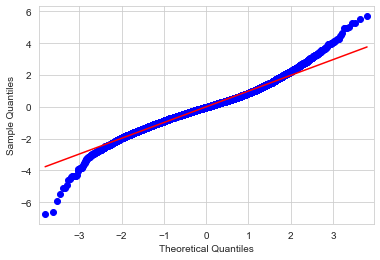

In [53]:
# Q-Q plot
residuals = model3.resid
fig3 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig3.show()

The "tails" on the Q-Q plot are closer to normal, but the model is not that much better at predicting house prices than the model without a log transformation. Let's use the model that hasn't been log-transformed going forward to easily understand the features.

## Model 6: Remove Outliers 
AKA: Fix those tails!

In [54]:
# Removing outliers will mean some features will not have data 
# these are the features that will be left
df5 = df[['price', 'quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11',
       'condition', 'yr_built', 'sqft_lot',
       'bath_2', 'floors', 'bed_2']]

In [55]:
# Remove everything after 3 standard deviations
df5 = df5[(np.abs(stats.zscore(df5)) < 3).all(axis=1)]

In [56]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18476 entries, 0 to 18917
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        18476 non-null  float64
 1   quad_SE      18476 non-null  int64  
 2   quad_SW      18476 non-null  int64  
 3   sqft_living  18476 non-null  int64  
 4   grade_9_11   18476 non-null  int64  
 5   condition    18476 non-null  int64  
 6   yr_built     18476 non-null  int64  
 7   sqft_lot     18476 non-null  int64  
 8   bath_2       18476 non-null  int64  
 9   floors       18476 non-null  int64  
 10  bed_2        18476 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.7 MB


We didn't lose a lot of data doing that. Nice!
Let's see how it affects our model.

In [57]:
y = df5['price']
X = df5.drop('price', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 32)
df_train5 = pd.concat([X_train, y_train], axis= 1)

In [58]:
y = df_train5['price']
X = df_train5.drop('price', axis= 1)

X_int = sm.add_constant(X)
model5 = sm.OLS(y, X_int).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     2428.
Date:                Thu, 21 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:48:16   Log-Likelihood:            -1.7958e+05
No. Observations:               13857   AIC:                         3.592e+05
Df Residuals:                   13846   BIC:                         3.593e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.599e+06   7.83e+04     20.424      0.000    1.45e+06    1.75e+06
quad_SE     -1.749e+05   2490.091    -70.252      0.000    -1.8e+05    -1.7e+05
quad_SW     -1.941e+05   2490.081    -77.952      0.000   -1.99e+05   -1.89e+05
sqft_living   121.2928      1.749     69.349      0.000     117.864     124.721
grade_9_11   9.278e+04   3195.221     29.039      0.000    8.65e+04     9.9e+04
condition    2.093e+04   1502.624     13.931      0.000     1.8e+04    2.39e+04
yr_built     -739.6783     39.448    -18.751      0.000    -817.001    -662.355
sqft_lot        0.5768      0.080      7.217      0.000       0.420       0.734
bath_2       1.499e+04   2066.362      7.252      0.000    1.09e+04     1.9e+04
floors       2.617e+04   1805.617     14.493      0.000    2.26e+04    2.97e+04
bed_2        5515.1561   2795.661      1.973      0.049      35.283     1.1e+04
==============================================================================
Omnibus:                      478.924   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.080
Skew:                           0.347   Prob(JB):                    9.54e-153
Kurtosis:                       3.854   Cond. No.                     1.39e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### RMSE & Accuracy

In [59]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
diff = test_rmse - train_rmse
print (diff)

print ('Train RMSE: ', train_rmse)
print ('Test RMSE: ', test_rmse)

-1197.1972514815716
Train RMSE:  102830.26825614936
Test RMSE:  101633.07100466779


In [60]:
print ('Accuracy score - train: ', linreg.score(X_train, y_train)*100)
print ('Accuracy score - test:', linreg.score(X_test, y_test)*100)

Accuracy score - train:  63.68439987976458
Accuracy score - test: 63.77027827948969


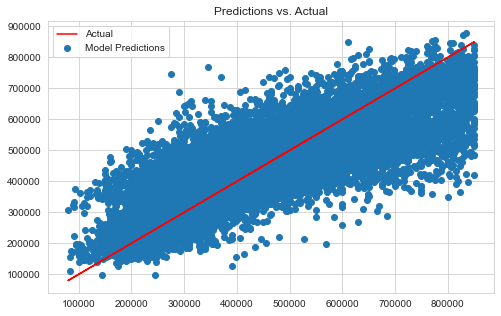

In [61]:
# Get predictions
y_pred = linreg.predict(X_train)

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Predictions vs. Actual')
plt.legend()
plt.show()

### Q-Q Plot

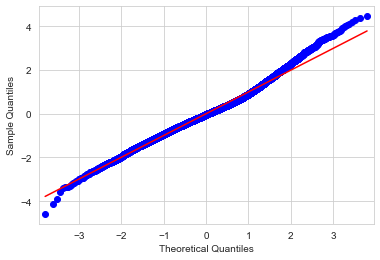

In [62]:
residuals = model5.resid
fig5 = sm.graphics.qqplot(residuals, dist=stats.norm, line='r', fit=True)
fig5.show()

### Check regression assumptions in error terms

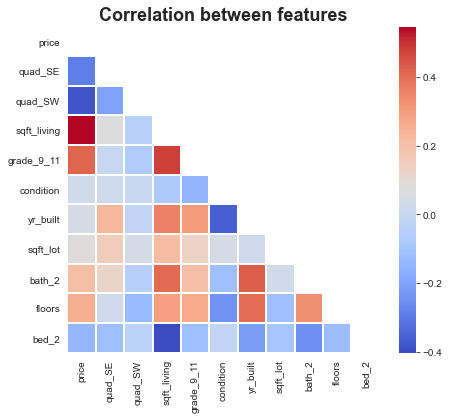

In [63]:
corr = df5.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df5.corr(), cmap= 'coolwarm', mask= mask, linewidths= 1)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

While this data is the most normally distributed, it does a poorer job at predicting sale prices, with only being able to explain 63.7% of variations in price and having a larger range of error. This is similar to our model where we did not use zip codes. As you can see, this model did not use zip codes either and it definitely affects the model's efficacy.

## Winning Model -- 4

Due to it's ease of interpretation and accuracy, it is the model that would be most useful to predict home sale prices in King County for first time home buyers.

quad_SE


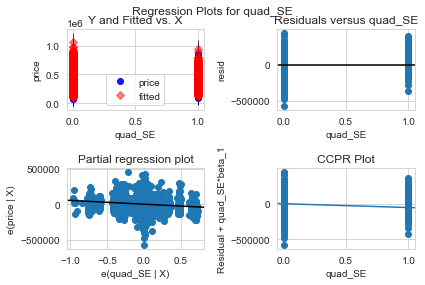

quad_SW


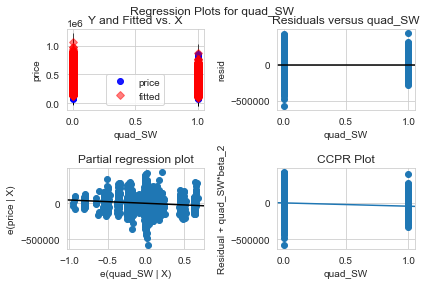

sqft_living


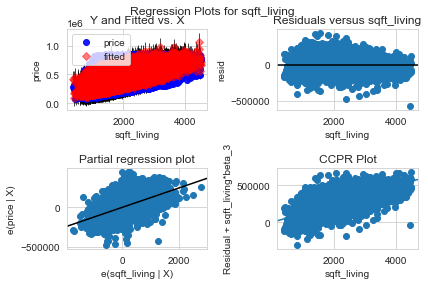

grade_9_11


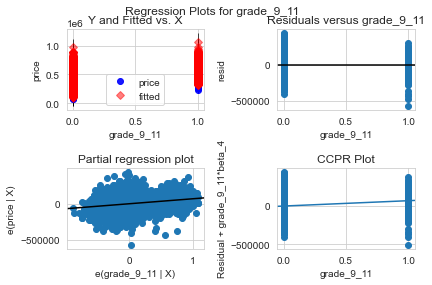

viewed


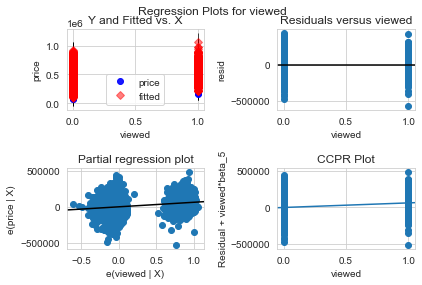

condition


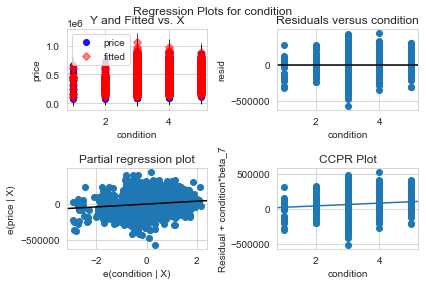

zip_98004


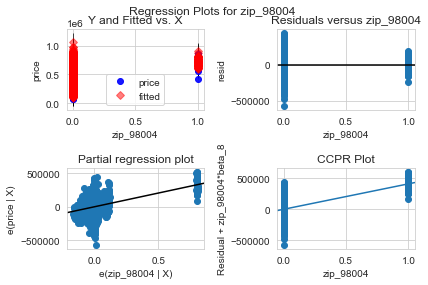

yr_built


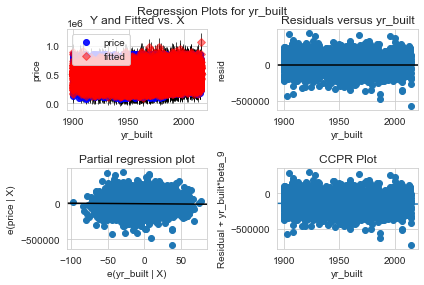

waterfront


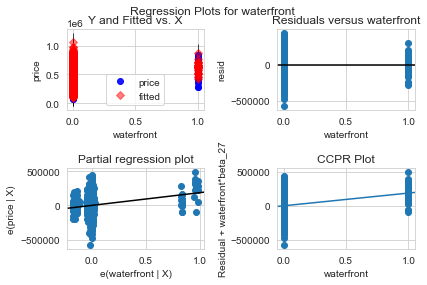

has_basement


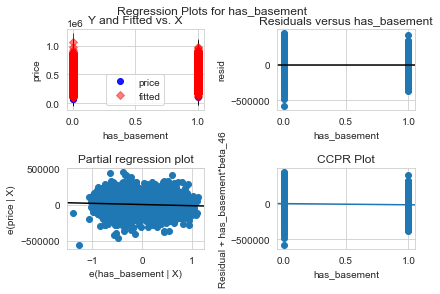

had_renovation


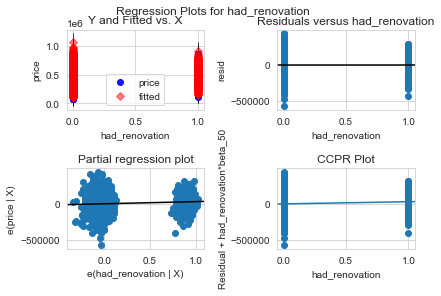

bed_6


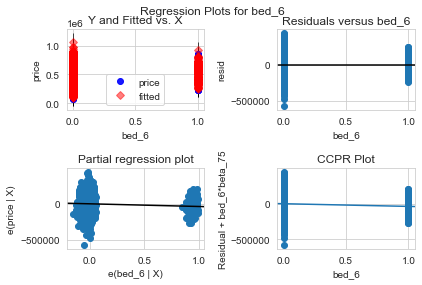

bath_2


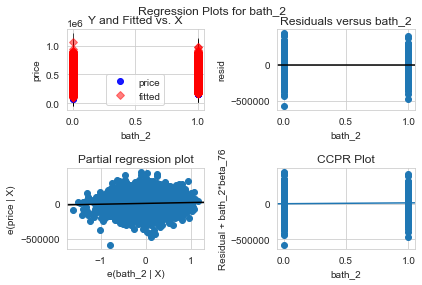

bath_3


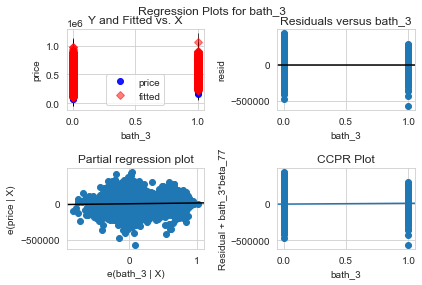

In [64]:
labels = ['quad_SE', 'quad_SW', 'sqft_living', 'grade_9_11', 'viewed',
          'condition', 'zip_98004', 'yr_built', 'waterfront', 'has_basement',
          'had_renovation', 'bed_6', 'bath_2', 'bath_3']

for ind, i in enumerate(labels):
    print (labels[ind])
    sm.graphics.plot_regress_exog(model2, i)
    plt.show()

## Conclusion

The model that does the best at predicting house sale prices for first time home buyers was the fourth model. Interestingly, this model did not need any normalization or log transformations to perform better.

The model can explain 80% of variations in price and the average error is around \\$76,884.

* The model shows a relationship between sale price and the year a house was built. One might expect a house's value to go down approximately \\$75 every year it gets older.

* The model also shows that increasing the size of your home will increase the value. For every square foot of living space, one could expect an extra \\$123 on the sale price.

* Adding square footage to the lot does increase the value of property- about .44 cents for every square foot. That may not sound like a lot of money, but we kept lots that were up to 750,000 square feet. That can add up if you have a lot of land.

**_Recommendations to First Time Home Buyers:_**

* First time home buyers should make sure they are buying houses between the months of October through March to avoid paying more for the same house the in spring and summer months.

* They may also choose to look at homes south of longitude 47.5 if they are looking to spend less.

* Most houses have average or higher than average grades and conditions. Houses should be "move-in ready" in most cases.

* If the buyer is wanting extra features like properties on the water, they may have to wait longer or choose from a limited selection.

* Find properties on your own or use alternative methods. Houses that are viewed by more people end up costing more - from \\$128,000 to \\$201,000, on average.

## Future Work

Other topics that would be good to evaluate for first time home buyers in the future include: 
* Commute times
* Surrounding amenities such as schools, parks, restaurants, grocery stores, hospitals and other places of interest 
* Vicinity to public transportation or walk-ability
* Comparing to newer data
* Estimating other costs like home insurance and taxes